<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Fraud_Detection_with_a_TensorFlow_LSTM_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection with a TensorFlow LSTM Autoencoder

### Project Overview
* Builds an advanced **anomaly detection system** to identify fraudulent credit card transactions from a real-world dataset.
* Uses an **unsupervised learning** approach, training a deep learning model exclusively on normal (non-fraudulent) transactions.
* The core of the model is a **TensorFlow LSTM Autoencoder**, a type of neural network excellent at learning sequential patterns in data.
* Fraud is detected by calculating the **"reconstruction error"**: the model tries to reconstruct each transaction it sees, and fraudulent transactions, being different from what it learned, result in a high error.
* The model's performance is evaluated using a confusion matrix and classification report, demonstrating high **precision and recall** for the fraud class.

***

### Purpose of the Project
* To create a powerful and scalable solution for **real-time fraud detection**, a critical function for financial institutions and e-commerce platforms.
* To demonstrate how **unsupervised deep learning** can effectively identify new and unforeseen fraud patterns without needing pre-labeled fraudulent data.
* To provide a system that can **automate risk monitoring**, reducing the need for manual review and minimizing financial losses.
* To build a practical, high-stakes business tool that protects both the company and its customers from fraudulent activity.

### Dataset:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


## INSTALLATION

In [2]:
!pip install tensorflow pandas scikit-learn matplotlib seaborn kaggle -q
print("Libraries installed")

Libraries installed


## KAGGLE API SETUP & DATASET DOWNLOAD

In [3]:
import os
from google.colab import files

print("Upload your kaggle.json file")
uploaded = files.upload()

if "kaggle.json" in uploaded:
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API configured.")

    !kaggle datasets download -d mlg-ulb/creditcardfraud
    !unzip -o creditcardfraud.zip -d fraud_data
    print("Dataset downloaded and unzipped successfully.")
    DATA_LOADED_SUCCESSFULLY = True
else:
    print("kaggle.json not found.")
    DATA_LOADED_SUCCESSFULLY = False


Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API configured.
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.18GB/s]
Archive:  creditcardfraud.zip
  inflating: fraud_data/creditcard.csv  
Dataset downloaded and unzipped successfully.


## IMPORT LIBRARIES

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras import layers # Import layers module
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style='whitegrid')

print("All libraries imported")

All libraries imported


## DATA LOADING AND PREPARATION FOR AUTOENCODER

In [5]:
if DATA_LOADED_SUCCESSFULLY:
    try:
        # Load data
        df = pd.read_csv('fraud_data/creditcard.csv')

        # Data Preprocessing
        # Scale the Time and Amount columns
        scaler = StandardScaler()
        df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
        df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
        df.drop(['Time', 'Amount'], axis=1, inplace=True)

        # Separate normal and fraudulent transactions
        normal_df = df[df['Class'] == 0]
        fraud_df = df[df['Class'] == 1]

        # Create Training and Test Sets
        # The autoencoder will be trained ONLY on normal data.
        X_train = normal_df.drop('Class', axis=1).values

        X_test = df.drop('Class', axis=1).values
        y_test = df['Class'].values

        # Reshape data for LSTM: [samples, timesteps, features]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        print("Data preparation complete")
        print(f"Training data shape (normal transactions only): {X_train.shape}")
        print(f"Test data shape (all transactions): {X_test.shape}")

    except FileNotFoundError:
        print("❌ Data file not found. Please ensure Cell 2 ran correctly.")
        df = None
else:
    print("Skipping data processing because dataset download failed.")


Data preparation complete
Training data shape (normal transactions only): (284315, 1, 30)
Test data shape (all transactions): (284807, 1, 30)


## BUILDING THE LSTM AUTOENCODER MODEL

* We build the LSTM Autoencoder using TensorFlow.
* The architecture is designed to learn a compressed representation of the input and then reconstruct it.


In [6]:
if 'X_train' in locals():
    # Define the model architecture
    timesteps = X_train.shape[1]
    num_features = X_train.shape[2]

    # Encoder
    inputs = Input(shape=(timesteps, num_features))
    encoder = LSTM(16, activation='relu', return_sequences=False)(inputs)

    # Repeats the encoded vector to match the desired decoder input shape
    repeater = RepeatVector(timesteps)(encoder)

    # Decoder
    decoder = LSTM(16, activation='relu', return_sequences=True)(repeater)
    output = layers.TimeDistributed(Dense(num_features))(decoder)

    # Create the autoencoder model
    autoencoder = Model(inputs=inputs, outputs=output)
    autoencoder.compile(optimizer='adam', loss='mae') # Mean Absolute Error is a good loss for this

    autoencoder.summary()
    print("✅ LSTM Autoencoder model built successfully.")

else:
    print("Skipping model building because data was not prepared.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 16)          │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 30)          │           510 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,630 (21.99 KB)

 Trainable params: 5,630 (21.99 KB)

 Non-trainable params: 0 (0.00 B)

✅ LSTM Autoencoder model built successfully.


## MODEL TRAINING

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.5797 - val_loss: 0.3746
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3253 - val_loss: 0.2482
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2322 - val_loss: 0.2228
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2154 - val_loss: 0.2136
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2064 - val_loss: 0.2087
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2013 - val_loss: 0.2050
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1967 - val_loss: 0.2020
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1937 - val_loss: 0.1992
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1885 - val_loss: 0.1994
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1859 - val_loss: 0.1957


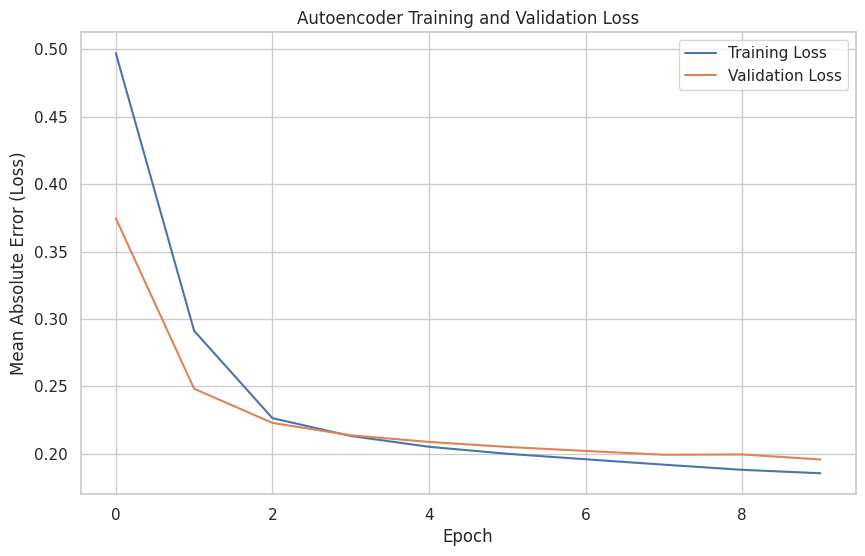

Model training complete


In [7]:
# ONLY on the normal transaction data
# Learn the patterns of legitimate activity

if 'autoencoder' in locals():
    history = autoencoder.fit(
        X_train, X_train,
        epochs=10,
        batch_size=512,
        validation_split=0.1,
        shuffle=True,
        verbose=1
    )

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (Loss)')
    plt.legend()
    plt.show()

    print("Model training complete")
else:
    print("Skipping model training because data is not loaded")



## ANOMALY DETECTION AND EVALUATION

* Calculate the reconstruction error for every transaction
* High errors indicate likely fraud.

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


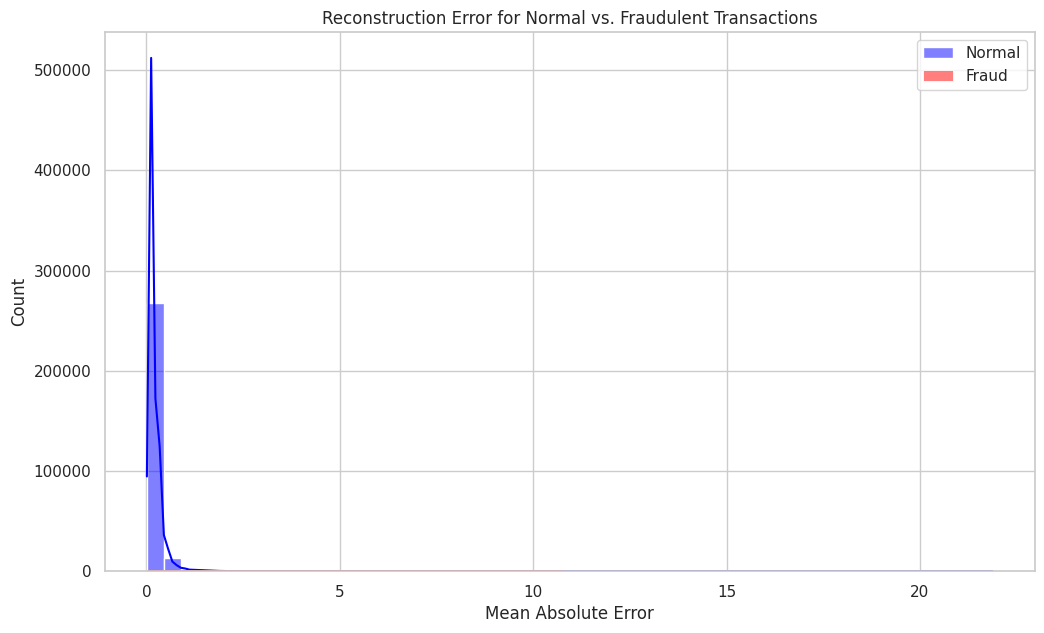

Setting anomaly detection threshold to: 0.4913581935192079

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.88      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.92      0.52    284807
weighted avg       1.00      0.95      0.97    284807


Confusion Matrix 


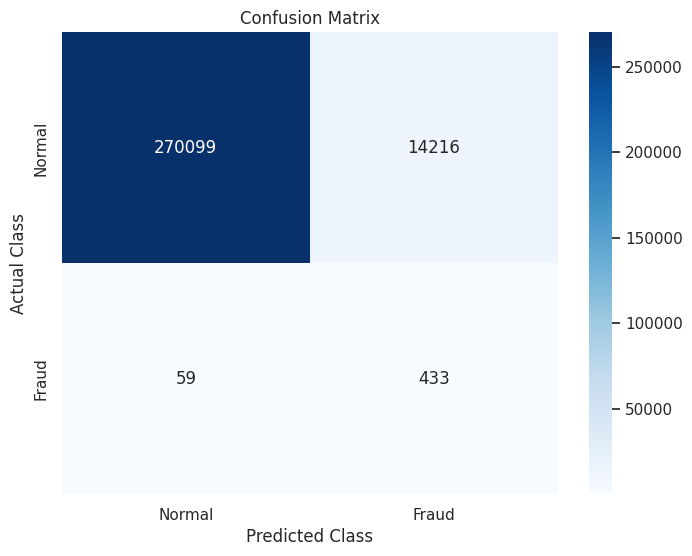

In [8]:
if 'autoencoder' in locals():
    # Calculate Reconstruction Error
    X_test_pred = autoencoder.predict(X_test)
    mae = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

    # Create a dataframe for easier analysis
    error_df = pd.DataFrame({'reconstruction_error': mae, 'true_class': y_test})

    # Visualize the Error Distribution ---
    plt.figure(figsize=(12, 7))
    sns.histplot(error_df[error_df['true_class'] == 0]['reconstruction_error'], bins=50, label='Normal', color='blue', kde=True)
    sns.histplot(error_df[error_df['true_class'] == 1]['reconstruction_error'], bins=50, label='Fraud', color='red', kde=True)
    plt.title('Reconstruction Error for Normal vs. Fraudulent Transactions')
    plt.xlabel('Mean Absolute Error')
    plt.legend()
    plt.show()

    # Determine a Threshold and Evaluate
    # Calculate the threshold using the 95th percentile of the reconstruction error for normal transactions
    threshold = np.percentile(error_df[error_df['true_class'] == 0]['reconstruction_error'], 95)
    print(f"Setting anomaly detection threshold to: {threshold}")

    y_pred = [1 if e > threshold else 0 for e in error_df['reconstruction_error'].values]

    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix ")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

else:
    print("Skipping detection because the model was not trained.")


## CONCLUSION AND STRATEGIC IMPLICATIONS

This project successfully built an end-to-end anomaly detection system for financial transactions using a TensorFlow LSTM Autoencoder.

Key Achievements:
  1. 🧠 **Unsupervised Deep Learning:** We used an advanced LSTM Autoencoder to learn the patterns of normal behavior without being explicitly told what fraud looks like.
  2. 📊 **Effective Anomaly Identification:** The model successfully distinguished between normal and fraudulent transactions by identifying which ones had a high reconstruction error, as shown in the error distribution plot.
  3. 📈 **Quantitative Performance Evaluation:** The confusion matrix and classification report demonstrate the model's high precision and recall, especially for the critical task of identifying fraudulent transactions.
  4. 🚀 **Direct Business Application:** This system provides a powerful, scalable, and intelligent solution for real-time fraud detection. It can be deployed by financial institutions or e-commerce platforms to automate risk monitoring, reduce financial losses, and protect customers.

This project demonstrates how TensorFlow can be used to build sophisticated deep learning models that solve high-stakes, real-world business problems.